In [1]:
from model.generator_cbam import AttnUNet
import matplotlib.pyplot as plt
import numpy as np
import cv2
from dataset import *
from losses import *
from sim import psnr_error, ssim_error, heatmap
import torch.nn.functional as F

In [2]:
def imshow(img, mu=-500, std=500):
    '''
    input: tensor [1, h, w]
    '''
    img = img[0] # to (h, w)
    img = img * std + mu
    plt.figure(figsize=(5,5))   
    plt.imshow(img.numpy(), cmap='bone')
    plt.axis('off')
    plt.show()
    plt.close()
    return img

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
batch_size = 16
test_path = 'data/testset.npy'
test_set = npyDataset(npy_file=test_path, resize_h=256, resize_w=256)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Testing

In [5]:
resolution = 256
in_channels = 1
out_channels = 1

SAVE_PATH = './weight/attn_gan_generator_best.pth'

In [6]:
generator = AttnUNet(in_channels, out_channels).to(device)
generator.eval()

try:
    generator.load_state_dict(torch.load(SAVE_PATH))
    print('load model ok!')
except:
    print('error')

load model ok!


1. PSNR

(1) input(qd) - target(nd)

In [7]:
psnr_sum = 0

for i, data in enumerate(test_loader, 0):
    target, input = data
    target = target.to(device)
    input = input.to(device)
    psnr_sum += psnr_error(input, target)

psnr_avg = psnr_sum / len(test_loader)
print('psnr([qd, nd]:', psnr_avg)

psnr([qd, nd]: 33.78583356698258


(2) output(pred) - target(nd)

In [8]:
psnr_sum2 = 0

for i, data in enumerate(test_loader, 0):
    target, input = data
    target = target.to(device)
    input = input.to(device)

    out = generator(input)
    psnr_sum2 += psnr_error(out.cpu(), target.cpu())
    
psnr_avg2 = psnr_sum2 / len(test_loader)
print('psnr([PRED, nd]:', psnr_avg2)

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


psnr([PRED, nd]: 36.17765081034578


2. SSIM

(1) input(qd) - target(nd)

In [9]:
ssim_sum = 0

for i, data in enumerate(test_loader, 0):
    target, input = data
    target = target.to(device)
    input = input.to(device)
    ssim_sum += ssim_error(input, target)

ssim_avg = ssim_sum / len(test_loader)
print('ssim([qd, nd]:', ssim_avg)

ssim([qd, nd]: 0.8532261348331079


(2) output(pred) - target(nd)

In [10]:
ssim_sum2 = 0

for i, data in enumerate(test_loader, 0):
    target, input = data
    target = target.to(device)
    input = input.to(device)

    out = generator(input)
    ssim_sum2 += ssim_error(out, target)

ssim_avg2 = ssim_sum2 / len(test_loader)
print('ssim([PRED, nd]:', ssim_avg2)

ssim([PRED, nd]: 0.9224878011992047


3. Visualization

(random)

In [22]:
# get random image
r = np.random.randint(0, 10)

# get static image
for i, data in enumerate(test_loader):
    target, input = data
    target = target.to(device)
    input = input.to(device)
    out = generator(input)
    if i == r:
        break

target = target.cpu()[0,0]
input = input.cpu()[0,0]
out = out.cpu().detach()[0,0]

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(static)

In [25]:
# get static image
for data in test_loader:
    target, input = data
    target = target.to(device)
    input = input.to(device)
    out = generator(input)
    break

target = target.cpu()[0,0]
input = input.cpu()[0,0]
out = out.cpu().detach()[0,0]

psnr_qdct: 35.676940731511124
ssim_qdct: 0.916091536003151

psnr_pred: 36.48746342766953
ssim_ndct: 0.9531318338310939


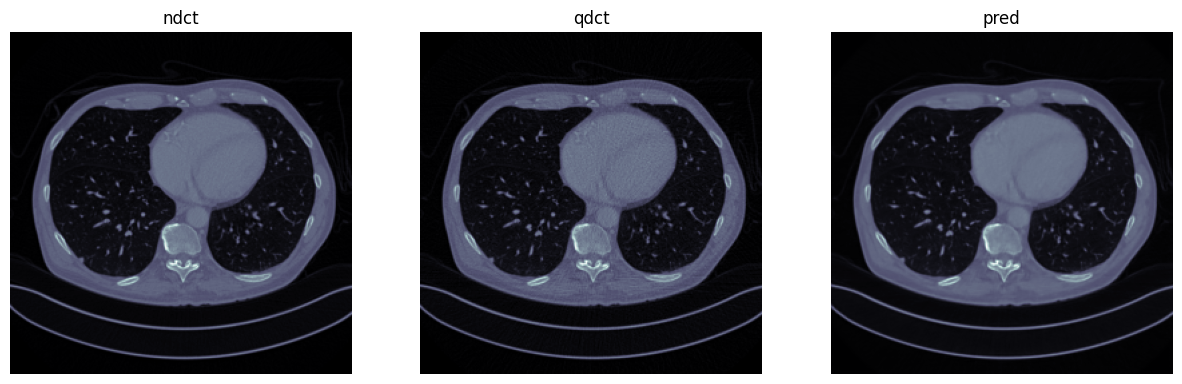

In [26]:
f, axs = plt.subplots(1, 3, figsize=(15, 15))

# ndct
plt.subplot(1,3,1)
plt.imshow(target, cmap='bone')
plt.title(f"ndct")
plt.axis('off')

# qdct
plt.subplot(1,3,2)
plt.imshow(input, cmap='bone')
plt.title(f"qdct")
plt.axis('off')

# pred
plt.subplot(1,3,3)
plt.imshow(out, cmap='bone')
plt.title(f"pred")
plt.axis('off')

# sim
psnr_qdct = psnr_error(input, target)
ssim_qdct = ssim_error(input, target)

print(f'psnr_qdct:',psnr_qdct)
print(f'ssim_qdct:',ssim_qdct)

psnr_pred = psnr_error(out, target)
ssim_ndct = ssim_error(out, target)

print(f'\npsnr_pred:',psnr_pred)
print(f'ssim_ndct:',ssim_ndct)

heatmap

(-0.5, 255.5, 255.5, -0.5)

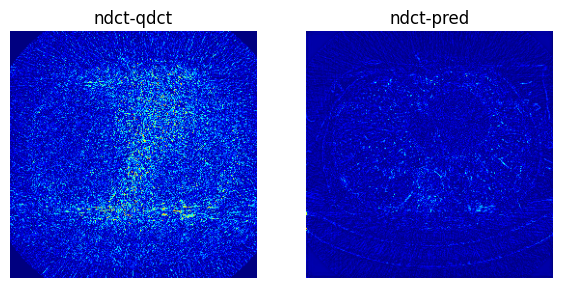

In [27]:
f, axs = plt.subplots(1, 2, figsize=(7, 7))

# ndct-qdct
plt.subplot(1,2,1)
hmap = heatmap(input, target)
plt.imshow(hmap, cmap='bone')
plt.title(f"ndct-qdct")
plt.axis('off')

# ndct-pred
plt.subplot(1,2,2)
hmap = heatmap(out, target)
plt.imshow(hmap, cmap='bone')
plt.title(f"ndct-pred")
plt.axis('off')